# Statistics Coded: How do women and men use their time - statistics 

This noteboook reproduces step by step the figures avialable in the original [Statistics Explaind page](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=How_do_women_and_men_use_their_time_-_statistics) and in the [source excel file](https://ec.europa.eu/eurostat/statistics-explained/images/2/2e/SE_Article_Charts_HETUS_2010_FINAL_06.09.2019.xlsx).

## Figure 1: Mean time spent on daily activities, all individuals by country, (hh:mm; 2008 to 2015)


The data is in the *tus_00age* dataset. We use the [restatapi](https://github.com/eurostat/restatapi) package to download the data. We apply filter to the data for the year (`date_filter=2010`) and for the values in the graph (`filters=list(unit="spent",age="total",sex="total",acl00=c("sleep","eat","^employ"," (family|personal) care","^leisure","^study","except travel"))`. If we use the REST SDMX service to get the filtered dataset, then we get no data because all the values are **NaN** (Not a Number) as the values are time spans. In order to get the data we have to apply the filter locally (`force_local_filter=T`) on the dataset retrieved from the bulk download facility.  

In [1]:
library(restatapi)
#dt<-get_eurostat_data("tus_00age",filters=list(unit="spent",age="total",sex="total",acl00="^(?!total).*$",geo="be"),date_filter=2010,label=F,ignore.case=T,exact_match=F,force_local_filter=T,perl=T)
#dt<-get_eurostat_data("tus_00age",filters=list(unit="spent",age="total",sex="total",acl00=c("ac01","ac02","ac03","ac1a","ac1b","ac2$","ac3$","ac4-8$","ac9a"),geo="be"),date_filter=2010,label=T,ignore.case=T,exact_match=F,force_local_filter=T,perl=T)
#dt<-get_eurostat_data("tus_00age",filters=list(unit="spent",age="total",sex="total",geo="be"),date_filter=2010,label=T,ignore.case=T,exact_match=F,force_local_filter=T,perl=T)
dt<-get_eurostat_data("tus_00age",filters=list(unit="spent",age="total",sex="total",acl00=c("sleep","eat","^employ"," (family|personal) care","^leisure","^study","except travel")),date_filter=2010,label=T,ignore.case=T,exact_match=F,perl=T)
dt
dt<-get_eurostat_data("tus_00age",filters=list(unit="spent",age="total",sex="total",acl00=c("sleep","eat","^employ"," (family|personal) care","^leisure","^study","except travel")),date_filter=2010,label=T,ignore.case=T,exact_match=F,perl=T,stringsAsFactors=F,force_local_filter=T)
dt


restatapi: - config file with the API version 1 loaded from GitHub (the 'current' API version number is 1).
           - 4 from the 32 cores are used for parallel computing, can be changed with 'options(restatapi_cores=...)'
           - 'auto' method will be used for file download, can be changed with 'options(restatapi_dmethod=...)'
           - the Table of contents (TOC) was not pre-loaded into the deafult cache ('.restatapi_env').



unit,sex,acl00,age,geo,time,values
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>


Forcing to apply filter locally. The whole dataset is downloaded through the raw download and the filters are applied locally.



unit,sex,age,acl00,geo,time,values
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Time spent (hh:mm),Total,Total,Sleep,Austria,2010,8:31
Time spent (hh:mm),Total,Total,Sleep,Belgium,2010,8:36
Time spent (hh:mm),Total,Total,Sleep,Germany (until 1990 former territory of the FRG),2010,8:26
Time spent (hh:mm),Total,Total,Sleep,Estonia,2010,8:50
Time spent (hh:mm),Total,Total,Sleep,Greece,2010,8:36
Time spent (hh:mm),Total,Total,Sleep,Spain,2010,8:38
Time spent (hh:mm),Total,Total,Sleep,Finland,2010,8:35
Time spent (hh:mm),Total,Total,Sleep,France,2010,8:30
Time spent (hh:mm),Total,Total,Sleep,Hungary,2010,8:34


Then we convert the values from characters/factors to time values using the *chron* package and keep only the columns with activities, countries and values. Before plotting the values, we need to sum the eating and other personal care for each country and cut the brackets from the name of Germany.

In [2]:
dt$geo<-gsub(" \\(.*\\)","",dt$geo)
if (is.factor(dt$values)|is.character(dt$values)) dt<-dt[,values:=chron::times(paste0(values,":00"))]
dt<-dt[,c("acl00","geo","values")]
sdt<-dt[grepl("(ating|ther)",acl00),.(acl00="Eating and other personal care",values=sum(values)),by=geo]
sdt
dt<-rbind(dt[!grepl("(ating|ther)",acl00)],sdt)

geo,acl00,values
<chr>,<chr>,<times>
Austria,Eating and other personal care,02:14:00
Belgium,Eating and other personal care,02:37:00
Germany,Eating and other personal care,02:38:00
Estonia,Eating and other personal care,02:16:00
Greece,Eating and other personal care,03:10:00
Spain,Eating and other personal care,02:50:00
Finland,Eating and other personal care,02:12:00
France,Eating and other personal care,03:05:00
Hungary,Eating and other personal care,02:58:00


Then plot the data using the *ggplot2* library, and using the color codes of the original figure.

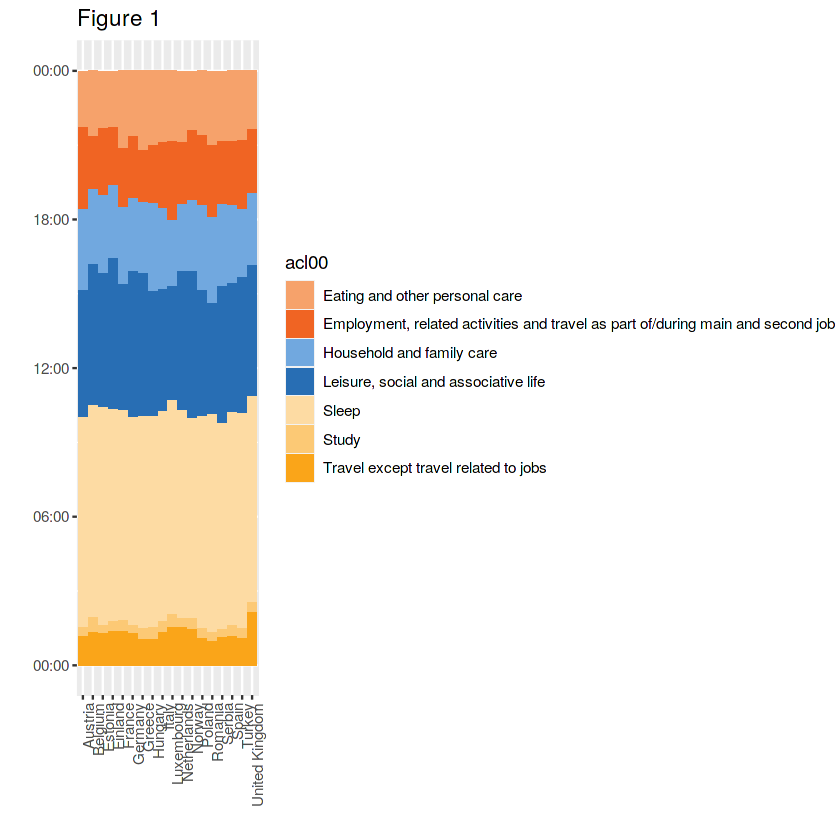

In [3]:
library(ggplot2)
library(chron)
mycolors<-c("#F6A26B","#F06423","#71A8DF","#286EB4","#FDDBA3","#FCC975","#FAA519")
ggplot(dt, aes(x=geo, y=values,fill=acl00)) + 
  geom_bar(position="stack",stat="identity")+
  scale_y_chron(format="%H:%M") +
  scale_fill_manual(values = mycolors)+
  ggtitle("Figure 1") +
  ylab ("")+
  xlab("")+
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

The graph not exactly as in the SE article, because in our case it is sorted alphabetically. We have to add the empty spaces before the EFTA and accession countries and reorder the values. Finally resize the plotting area to better see the figure. 

Warning message:
"Removed 2 rows containing missing values (position_stack)."


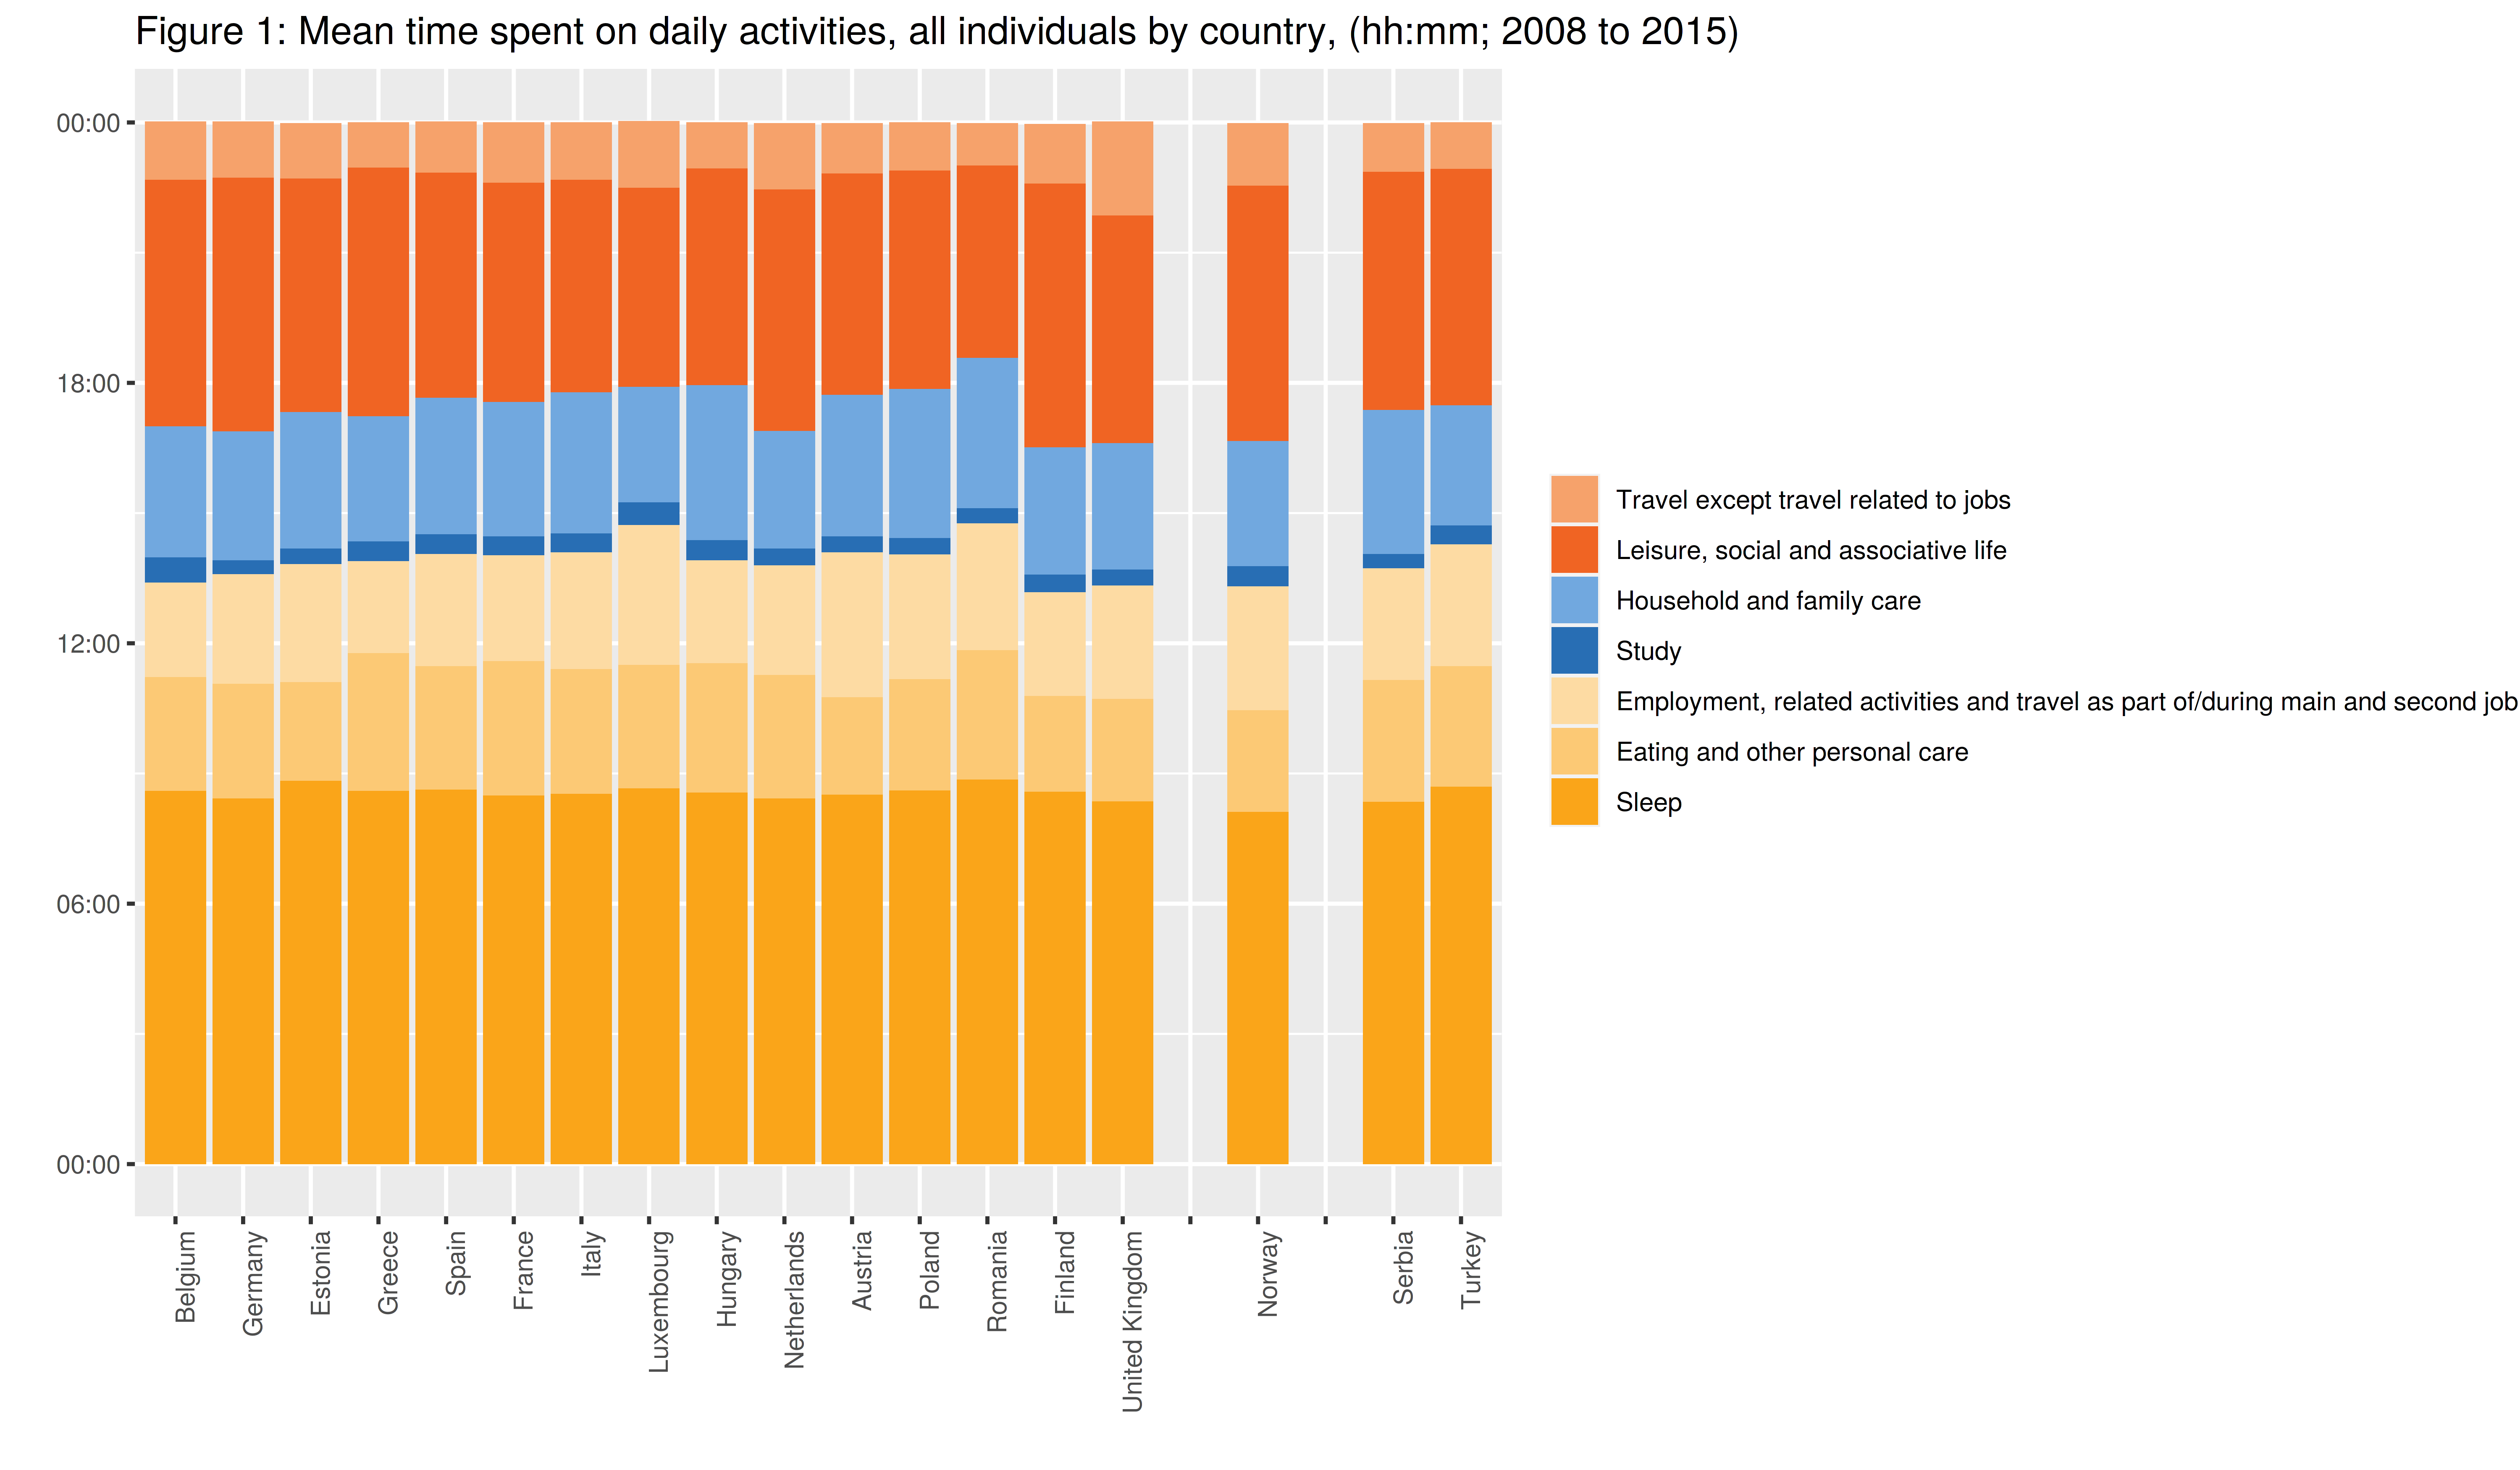

In [4]:
dt_sep<-data.table::data.table(acl00=c("Sleep","Sleep"),geo=c(" ","  "),values=c(chron::times(NA),chron::times(NA)))
dt<-rbind(dt,dt_sep)
acls_ord<-c('Travel except travel related to jobs','Leisure, social and associative life','Household and family care','Study','Employment, related activities and travel as part of/during main and second job','Eating and other personal care','Sleep')
dt$acl00<-factor(dt$acl00,levels=acls_ord)
geo_ord<-c('Belgium','Germany','Estonia','Greece','Spain','France','Italy','Luxembourg','Hungary','Netherlands','Austria','Poland','Romania','Finland','United Kingdom',' ','Norway','  ','Serbia','Turkey')
dt$geo<-factor(dt$geo,levels=geo_ord)

options(repr.plot.width=12, repr.plot.height=7,repr.plot.res=500)
ggplot(dt, aes(x=geo, y=values,fill=acl00)) + 
  geom_bar(position="stack",stat="identity")+
  scale_y_chron(format="%H:%M") +
  scale_fill_manual(values = mycolors)+
  ggtitle("Figure 1: Mean time spent on daily activities, all individuals by country, (hh:mm; 2008 to 2015)") +
  ylab("")+
  xlab("")+
  theme(legend.title = element_blank())+
  theme(axis.text.x = element_text(angle = 90, hjust = 1))